# Chapter 4: heating

## Setup

In [1]:
using Revise

using Ogre
import Onion
using WaterData
using DataFrames
using DataFramesMeta
using Plots
using ThesisUtils
using LaTeXStrings
using ProgressMeter
using BasicUnits
    bar = BasicUnits.bar;

Stacktrace:
 [1] depwarn(::String, ::Symbol) at ./deprecated.jl:70
 [2] #readtable#232(::Bool, ::Char, ::Array{Char,1}, ::Char, ::Array{String,1}, ::Array{String,1}, ::Array{String,1}, ::Bool, ::Int64, ::Array{Symbol,1}, ::Array{Any,1}, ::Bool, ::Char, ::Bool, ::Int64, ::Array{Int64,1}, ::Bool, ::Symbol, ::Bool, ::Bool, ::DataFrames.#readtable, ::String) at /home/sthomas/.julia/v0.6/DataFrames/src/deprecated.jl:1045
 [3] (::DataFrames.#kw##readtable)(::Array{Any,1}, ::DataFrames.#readtable, ::String) at ./<missing>:0
 [4] include_from_node1(::String) at ./loading.jl:576
 [5] include(::String) at ./sysimg.jl:14
 [6] include_from_node1(::String) at ./loading.jl:576
 [7] eval(::Module, ::Any) at ./boot.jl:235
 [8] _require(::Symbol) at ./loading.jl:490
 [9] require(::Symbol) at ./loading.jl:405
 [10] include_string(::String, ::String) at ./loading.jl:522
 [11] execute_request(::ZMQ.Socket, ::IJulia.Msg) at /home/sthomas/.julia/v0.6/IJulia/src/execute_request.jl:180
 [12] (::Compat.#inner#

In [2]:
# Function to save figure data to a JLD file in the figdata directory
using JLD
datadir = "figdata/generated/"

"Save a dictionary of values into a JLD file"
function savefigdata(source, id, datadict)
    filename = joinpath(datadir, source, id) * ".jld"
    save(filename, datadict)
end

"Load a dictionary of values from a JLD file"
function loadfigdata(source, id)
    filename = joinpath(datadir, source, id) * ".jld"
    load(filename)
end

# Common plotting options
xaxis=(L"Mass $M$ / M$_⊕$", (1, 10))
yaxis=(L"Radius $R$ / R$_⊕$", (0, 4))

# Write a number like 10000 as 10^5 in LaTeX
function latex_power(x)
    x == 0 && return L"0"
    logx = round(Int, log10(x))
    latexstring("10^{$logx}")
end

# Add a unit to the nth (default 1st) item in a list of latex strings
function addunit!(labels, unit, n=1)
    l = labels[n]
    labels[n] = latexstring("$l\$\\,\$$unit")
end 

# Add a symbol (e.g. "κ = ") to the nth (default 1st) item in a list of latex strings
function addsym!(labels, symbol, n=1)
    l = labels[n]
    labels[n] = latexstring("\$$symbol = \$$l")
end

function isconstant(κ::Onion.Opacity)
    κ.α == 0 && κ.β == 0
end

# Convert parameter values into a title string
function parvalues(str, d)
    fwater = 100 - round(Int, d["f0"] * 100)
    Tirr0  = d["Tirr0"]
    M0 = d["M0"]
    κ0 = d["κ0"]
    γ0 = d["γ0"]
    ɛ0 = d["ɛ0"]
    Psurf0 = d["Psurf0"]
    replacements = Dict(
        "M0" => string(M0/M_earth) * L"$\,$M$_⊕$",
        "f0" => string(fwater) * "% water",
        "Tirr0" => string(Tirr0) * L"$\,$K",
        "κ0" => string(κ0) * L"$\,$m$^2$/kg",
        "γ0" => string(γ0),
        "ɛ0" => latex_power(ɛ0) * L"$\,$W/kg",
        "Psurf0" => string(Psurf0 / 1e5) * L"$\,$bar"
    )

    
    if d["κ0"] in (Onion.water_opacity, nothing) 
        replacements["κ0"] = "variable"
    end
    
    if d["κ0"] isa Onion.Opacity && isconstant(d["κ0"])
        replacements["κ0"] = "$(trunc(Int,κ0.C))" * L"$\,$m$^2$/kg"
    end
    
    for (s, r) in replacements
        str = replace(str, s, r, 1)
    end
    
    return str
end;

## Data generation

In [3]:
# Parameter exploration values
const Ms_ME = linspace(1.0, 10, 30)
const Ms = Ms_ME * M_earth
const ɛ0 = 1e-12 * W/kg
const Tirr0 = 300 * K
const fcore0 = 0.7
const firon = fcore0 * 1/3
const fsilicate = fcore0 * 2/3
const κ0 = Onion.water_opacity
const γ0 = 0.01
const M0 = 5M_earth
const Psurf0 = 100bar

shared_data = Dict(
    "Ms" => Ms,
    "f0" => fcore0,
    "Tirr0" => Tirr0,
    "M0" => M0,
    "κ0" => κ0,
    "γ0" => γ0,
    "ɛ0" => ɛ0,
    "Psurf0" => Psurf0);

In [5]:
function internal_heat()
    ɛs = [0, 1e-12, 1e-10, 1e-8] * W/kg |> reverse

    # As internal temp -> 0, atmosphere disappears
    N = length(ɛs) * length(Ms)
    p = Progress(N)
    Rs = map(ɛs) do ɛ
        map(Ms) do M
            next!(p)
            # s, r = Ogre.interior(M, firon, fsilicate, ɛ, Tirr0, κ0, γ0, Psurf0)
            htp = Onion.HeatedPlanet(M = M, T_irr = Tirr0, ε = ε, κ = κ0, γ = γ0, 
                                     f_core = firon, f_mantle = fsilicate)
            Onion.solve_radius(htp)
        end
    end
    
    data = Dict(
        shared_data...,
        "ɛs" => ɛs,
        "Rs" => Rs
    )
    
    savefigdata("onion", "internal-heat", data)
end

internal_heat()

Progress: 100%|█████████████████████████████████████████| Time: 0:04:02


In [6]:
function internal_heat_profiles()
    κs = [Onion.water_opacity, 
          Onion.ConstantOpacity(0), 
          Onion.ConstantOpacity(100)]
    ɛs = [0, 1e-12, 1e-10, 1e-8] * W/kg |> reverse
    
    N = length(ɛs) * length(κs)
    p = Progress(N)
    
    data = Dict()
    
    for κ in κs
        Ps = Vector{Float64}[]
        Ts = Vector{Float64}[]
        foreach(ɛs) do ɛ
            next!(p)
            if κ == Onion.ConstantOpacity(0)
                pl = Onion.ThreeLayerPlanet(M = M0, f_core = firon, f_mantle = fsilicate,
                                            T_surf = 300, P_surf = 1e-4,
                                            isothermal = true)
            else
                pl = Onion.HeatedPlanet(M = M0, f_core = firon, f_mantle = fsilicate, 
                                        ε = ε, T_irr = Tirr0, κ = κ, γ = γ0)
            end
            sol = Onion.structure(pl)
            P = sol[2, :]
            T = sol[3, :]
            push!(Ps, P)
            push!(Ts, T)
            # s, r = Ogre.interior(M0, firon, fsilicate, ɛ, Tirr0, κ, γ0, Psurf0)
            # P = Ogre.pressure(s)
            # T = Ogre.temperature(s)
            # Patm = P[P .< 10000bar]
            # Tatm = T[P .< 10000bar]
            # @assert length(Patm) == length(Tatm)
            # push!(Ps, Patm)
            # push!(Ts, Tatm)
        end
    
        data[string(κ)] = Dict(
            shared_data...,
            "ɛs" => ɛs,
            "Ps" => Ps,
            "κ0" => κ,
            "Ts" => Ts
        )
    end  
    
    savefigdata("onion", "internal-heat-profiles", data)
end
        
internal_heat_profiles()  

Progress: 100%|█████████████████████████████████████████| Time: 0:00:16


In [7]:
function irradiation()
    Tirrs = [300, 600, 1000] * K

    # As external temp -> 0, atmosphere disappears
    N = length(Tirrs) * length(Ms)
    p = Progress(N)
    reverse!(Tirrs)
    Rs = map(Tirrs) do Tirr
        map(Ms) do M
            next!(p)
#             s, r = Ogre.interior(M, firon, fsilicate, ɛ0, Tirr, κ0, γ0, Psurf0)
            htp = Onion.HeatedPlanet(M = M, T_irr = Tirr, ε = ε0, κ = κ0, γ = γ0, 
                                     f_core = firon, f_mantle = fsilicate)
            Onion.solve_radius(htp)
        end
    end
    
    data = Dict(
        shared_data...,
        "Tirrs" => Tirrs,
        "Rs" => Rs,
    )
    
    savefigdata("onion", "irradiation", data)
end

irradiation()

Progress:  99%|█████████████████████████████████████████|  ETA: 0:00:01

In [8]:
function irradiation_profiles()
    κs = [Onion.water_opacity, 
          Onion.ConstantOpacity(0), 
          Onion.ConstantOpacity(100)]
    Tirrs = [300, 600, 1000] * K |> reverse
    
    N = length(Tirrs) * length(κs)
    p = Progress(N)
    
    data = Dict()
    
    for κ in κs
        Ps = Vector{Float64}[]
        Ts = Vector{Float64}[]
        foreach(Tirrs) do Tirr
            next!(p) 
            htp = Onion.HeatedPlanet(M = M0, f_core = firon, f_mantle = fsilicate, 
                                     ε = ε0, T_irr = Tirr, κ = κ, γ = γ0)
            sol = Onion.structure(htp)
            P = sol[2, :]
            T = sol[3, :]
            push!(Ps, P)
            push!(Ts, T)
#             s, r = Ogre.interior(M0, firon, fsilicate, ɛ0, Tirr, κ, γ0, Psurf0)
#             P = Ogre.pressure(s)
#             T = Ogre.temperature(s)
#             Patm = P[P .< 100bar]
#             Tatm = T[P .< 100bar]
#             @assert length(Patm) == length(Tatm)
#             push!(Ps, Patm)
#             push!(Ts, Tatm)
        end

        data[string(κ)] = Dict(
            shared_data...,
            "Tirrs" => Tirrs,
            "κ0" => κ,
            "Ps" => Ps,
            "Ts" => Ts
        )
    end
    
    savefigdata("onion", "irradiation-profiles", data)
end   

irradiation_profiles()

Progress: 100%|█████████████████████████████████████████| Time: 0:01:21
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


In [9]:
function core_fraction()
    fs_percent = [30, 50, 70, 90, 97]
    fs = fs_percent / 100
    wfrac_percent = 100 .- fs_percent

    N = (length(fs)+1) * length(Ms)

    # As core fraction -> 1, atmosphere disappears
    p = Progress(N)
    Rs = map(fs) do f
        map(Ms) do M
            next!(p)
            htp = Onion.HeatedPlanet(M = M, T_irr = Tirr0, ε = ε0, κ = κ0, γ = γ0, 
                                     f_core = f/3, f_mantle = 2f/3)
            Onion.solve_radius(htp)
        end
    end
    Rs_rock = map(Ms) do M
        next!(p)
        htp = Onion.DryPlanet(M = M, T_surf = Tirr0, f_core = 1/3)
        Onion.solve_radius(htp)
    end
    
    data = Dict(
        shared_data...,
        "fs" => fs,
        "Rs" => Rs,
        "Rs_rock" => Rs_rock
    )
    
    savefigdata("onion", "core-fraction", data)
end

core_fraction()

Progress: 100%|█████████████████████████████████████████| Time: 0:04:59


In [10]:
function opacities()
    κs = Onion.ConstantOpacity.([1, 10, 100, 1000])

    # As opacity -> 0, atmosphere becomes isothermal
    N = (length(κs)) * length(Ms)
    p = Progress(N)
    reverse!(κs)
    Rs = map(κs) do κ
        map(Ms) do M
            next!(p)
            htp = Onion.HeatedPlanet(M = M, f_core = firon, f_mantle = fsilicate, 
                                     ε = ε0, T_irr = Tirr0, κ = κ, γ = γ0)
            Onion.solve_radius(htp)
#             s, r = Ogre.interior(M, firon, fsilicate, ɛ0, Tirr0, κ, γ0, Psurf0)
#             return r
        end
    end
    Rs_freeκ = map(Ms) do M
        next!(p)
        κ = Onion.water_opacity
        htp = Onion.HeatedPlanet(M = M, f_core = firon, f_mantle = fsilicate, 
                                 ε = ε0, T_irr = Tirr0, κ = κ, γ = γ0)
        Onion.solve_radius(htp)
#         s, r = Ogre.interior(M, firon, fsilicate, ɛ0, Tirr0, nothing, γ0, Psurf0)
#         return r
    end
    
    data = Dict(
        shared_data...,
        "κs" => κs,
        "Rs" => Rs,
        "Rs_freeκ" => Rs_freeκ
    )
    
    savefigdata("onion", "opacities", data)
end

opacities()

Progress: 100%|█████████████████████████████████████████| Time: 0:03:51


In [11]:
function opacity_ratio()
    γs = Any[1e-2, 1e-1, 1, 10]

    # As opacity -> 0, atmosphere becomes isothermal
    N = (length(γs)) * length(Ms)
    p = Progress(N)
    Rs = map(γs) do γ
        map(Ms) do M
            next!(p)
            htp = Onion.HeatedPlanet(M = M, f_core = firon, f_mantle = fsilicate, 
                                     ε = ε0, T_irr = Tirr0, κ = κ0, γ = γ)
            Onion.solve_radius(htp)
#             s, r = Ogre.interior(M, firon, fsilicate, ɛ0, Tirr0, κ0, float(γ), Psurf0)
#             return r
        end
    end
    
    data = Dict(
        shared_data...,
        "γs" => γs,
        "Rs" => Rs
    )
    
    savefigdata("onion", "opacity-ratios", data)
end

opacity_ratio()

Progress: 100%|█████████████████████████████████████████| Time: 0:03:40


In [12]:
# we'll use the scale height to get 
# an approximation of the atmospheric thickness

function scale_height(M, R, T)
    g = Ogre.surface_gravity(M, R)
    H = Ogre.scale_height(T, g)
end;

using NamedTuples

function transition_pars(T_int, T_irr)
    @NT(opacity = Onion.water_opacity,
        eos = Onion.h2o_with_ideal,
        heatcap = Onion.h2o_heatcap,
        thermexp = Onion.h2o_thermexp,
        T_int = T_int,
        T_irr = T_irr,
        μ = Onion.μ_isotropic,
        γ = 0.01)
end

transition_pars (generic function with 1 method)

In [13]:
function atmospheric_thickness()
    Nscale = 8

    Tirrs = [800] * K
    p = Progress(length(Ms) * length(Tirrs))
    
    dRs_full = Dict()
    dRs_bare = Dict()
    dHs = Dict()
    foreach(Tirrs) do T_irr
        Rs_full = []
        Rs_bare = []
        Hs = []
        foreach(Ms) do M
            next!(p)
            full_planet = Onion.AtmospherePlanet(M = M, T_irr = T_irr, T_int = 0K)
            full_planet_sol = Onion.structure(full_planet)
            pars = transition_pars(0K, T_irr)
            transition = Onion.find_transition(full_planet_sol, pars)
            m, rPTτ = transition
            r, P, T, τ = rPTτ
            bare_planet = Onion.ThreeLayerPlanet(M = m, T_surf = T, P_surf = P)
            r_bare = Onion.solve_radius(bare_planet)
            r_full = Onion.surface_radius(full_planet_sol)
            H = scale_height(M, r_bare, T)
            push!(Rs_full, r_full)
            push!(Rs_bare, r_bare)
            push!(Hs, H)
        end
        dRs_full[T_irr] = Rs_full
        dRs_bare[T_irr] = Rs_bare
        dHs[T_irr] = Hs
    end 
    
    data = Dict(
        shared_data...,
        "Rs_full" => dRs_full,
        "Rs_bare" => dRs_bare,
        "Hs" => dHs,
        "Tirrs" => Tirrs,
        "Nscale" => Nscale
    )
    
    savefigdata("onion", "atmospheric-thickness", data)
end

atmospheric_thickness()

LoadError: [91mBoundsError[39m

In [14]:
function internal_vs_external_heating()
    ɛs = [1e-12, 1e-10, 1e-8] |> reverse
    ɛ0 = 1e-20
    Tirr0 = 100K
    
    N = length(ɛs) * length(Ms)
    p = Progress(N)
    Rs_internal = []
    Rs_external_blackbody = []
    Rs_external_transition = []
    foreach(ɛs) do ɛ
        Rs_internal_inner = []
        Rs_external_blackbody_inner = []
        Rs_external_transition_inner = []
        foreach(Ms) do M
            next!(p)
            internally_heated_only = Onion.HeatedPlanet(M = M, T_irr = Tirr0, ε = ε)
            s_iho = Onion.structure(internally_heated_only)
            r_iho = Onion.surface_radius(s_iho)
            push!(Rs_internal_inner, r_iho)
            iho = internally_heated_only
            T_black_body = Onion.Tsurf_from_heat(iho.M, r_iho, iho.f_core, iho.ε)
            pars = transition_pars(T_black_body, Tirr0)
            transition = Onion.find_transition(s_iho, pars)
            T_transition = transition[2][3]
            
            externally_heated_method_1 = Onion.HeatedPlanet(M = M, T_irr = T_black_body, ε = ε0)
            r_ex1 = Onion.solve_radius(externally_heated_method_1)
            push!(Rs_external_blackbody_inner, r_ex1)
            
            externally_heated_method_2 = Onion.HeatedPlanet(M = M, T_irr = T_transition, ε = ε0)
            r_ex2 = Onion.solve_radius(externally_heated_method_2)
            push!(Rs_external_transition_inner, r_ex2)
        end
        push!(Rs_internal, Rs_internal_inner)
        push!(Rs_external_blackbody, Rs_external_blackbody_inner)
        push!(Rs_external_transition, Rs_external_transition_inner)
    end
    
    data = Dict(
        shared_data...,
        "ɛs" => ɛs,
        "Tirr0" => Tirr0,
        "Rs_internal" => Rs_internal,
        "Rs_external_transition" => Rs_external_transition,
        "Rs_external_blackbody" => Rs_external_blackbody
    )
    
    savefigdata("onion", "internal-vs-external", data)
end

internal_vs_external_heating()

LoadError: [91mBoundsError[39m

Progress:   3%|█                                        |  ETA: 0:00:08

## Plots

### Heating parameters

#### Internal heating

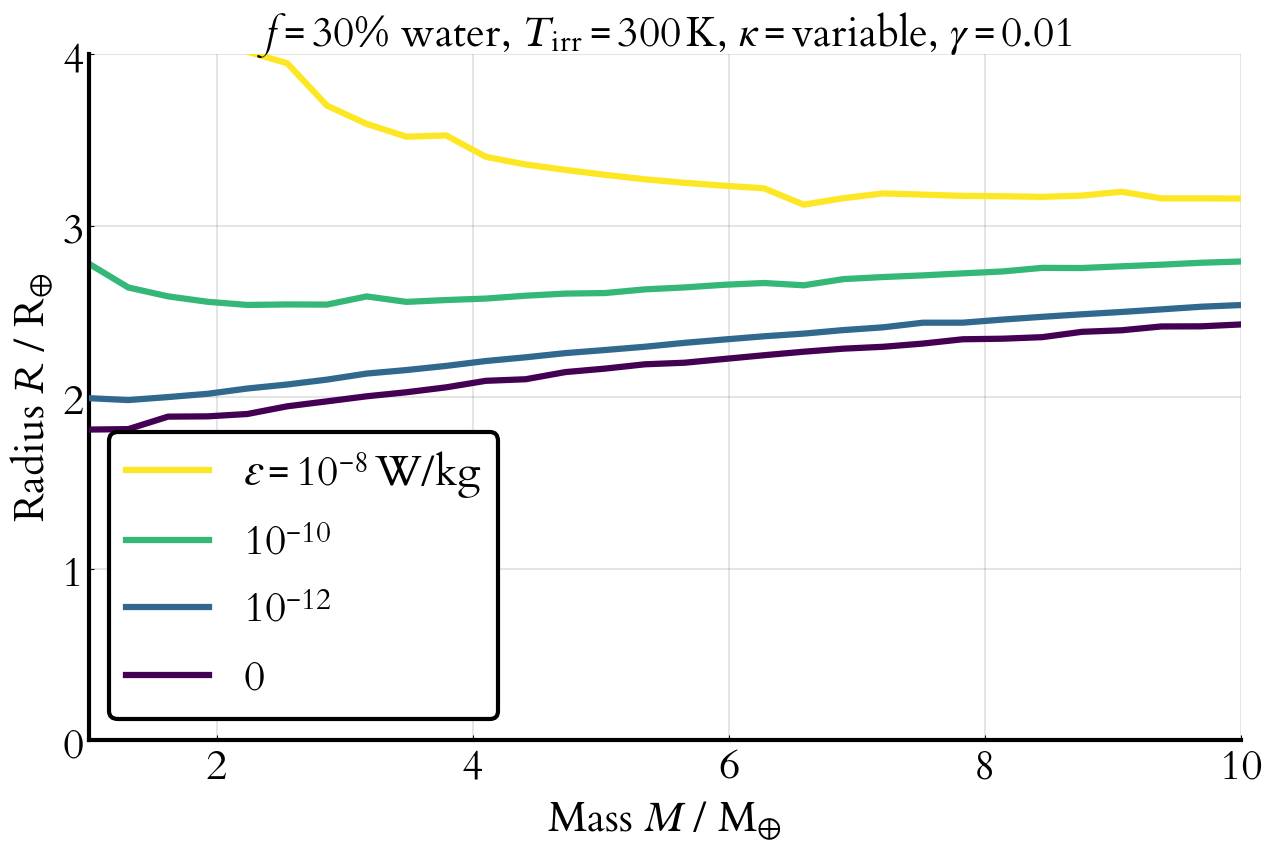

In [4]:
autofig("internal-heat", Normal) do
    d = loadfigdata("onion", "internal-heat")
    colors = seqcolors(:viridis, length(d["ɛs"])) |> reverse
    
    let ɛs = d["ɛs"], Ms = d["Ms"], Rs = d["Rs"]
        labels = latex_power.(ɛs) |> 
            x -> reshape(x, (1, :))
        addunit!(labels, "W/kg")
        addsym!(labels, "ɛ")
        title = parvalues(L"$f=$f0, $T_\mathrm{irr}=$Tirr0, $κ=$κ0, $γ=$γ0", d)
        
        plot(Ms/M_earth, Rs/R_earth, labels = labels, xaxis=xaxis, yaxis=yaxis, title=title, palette=colors)
    end
end;

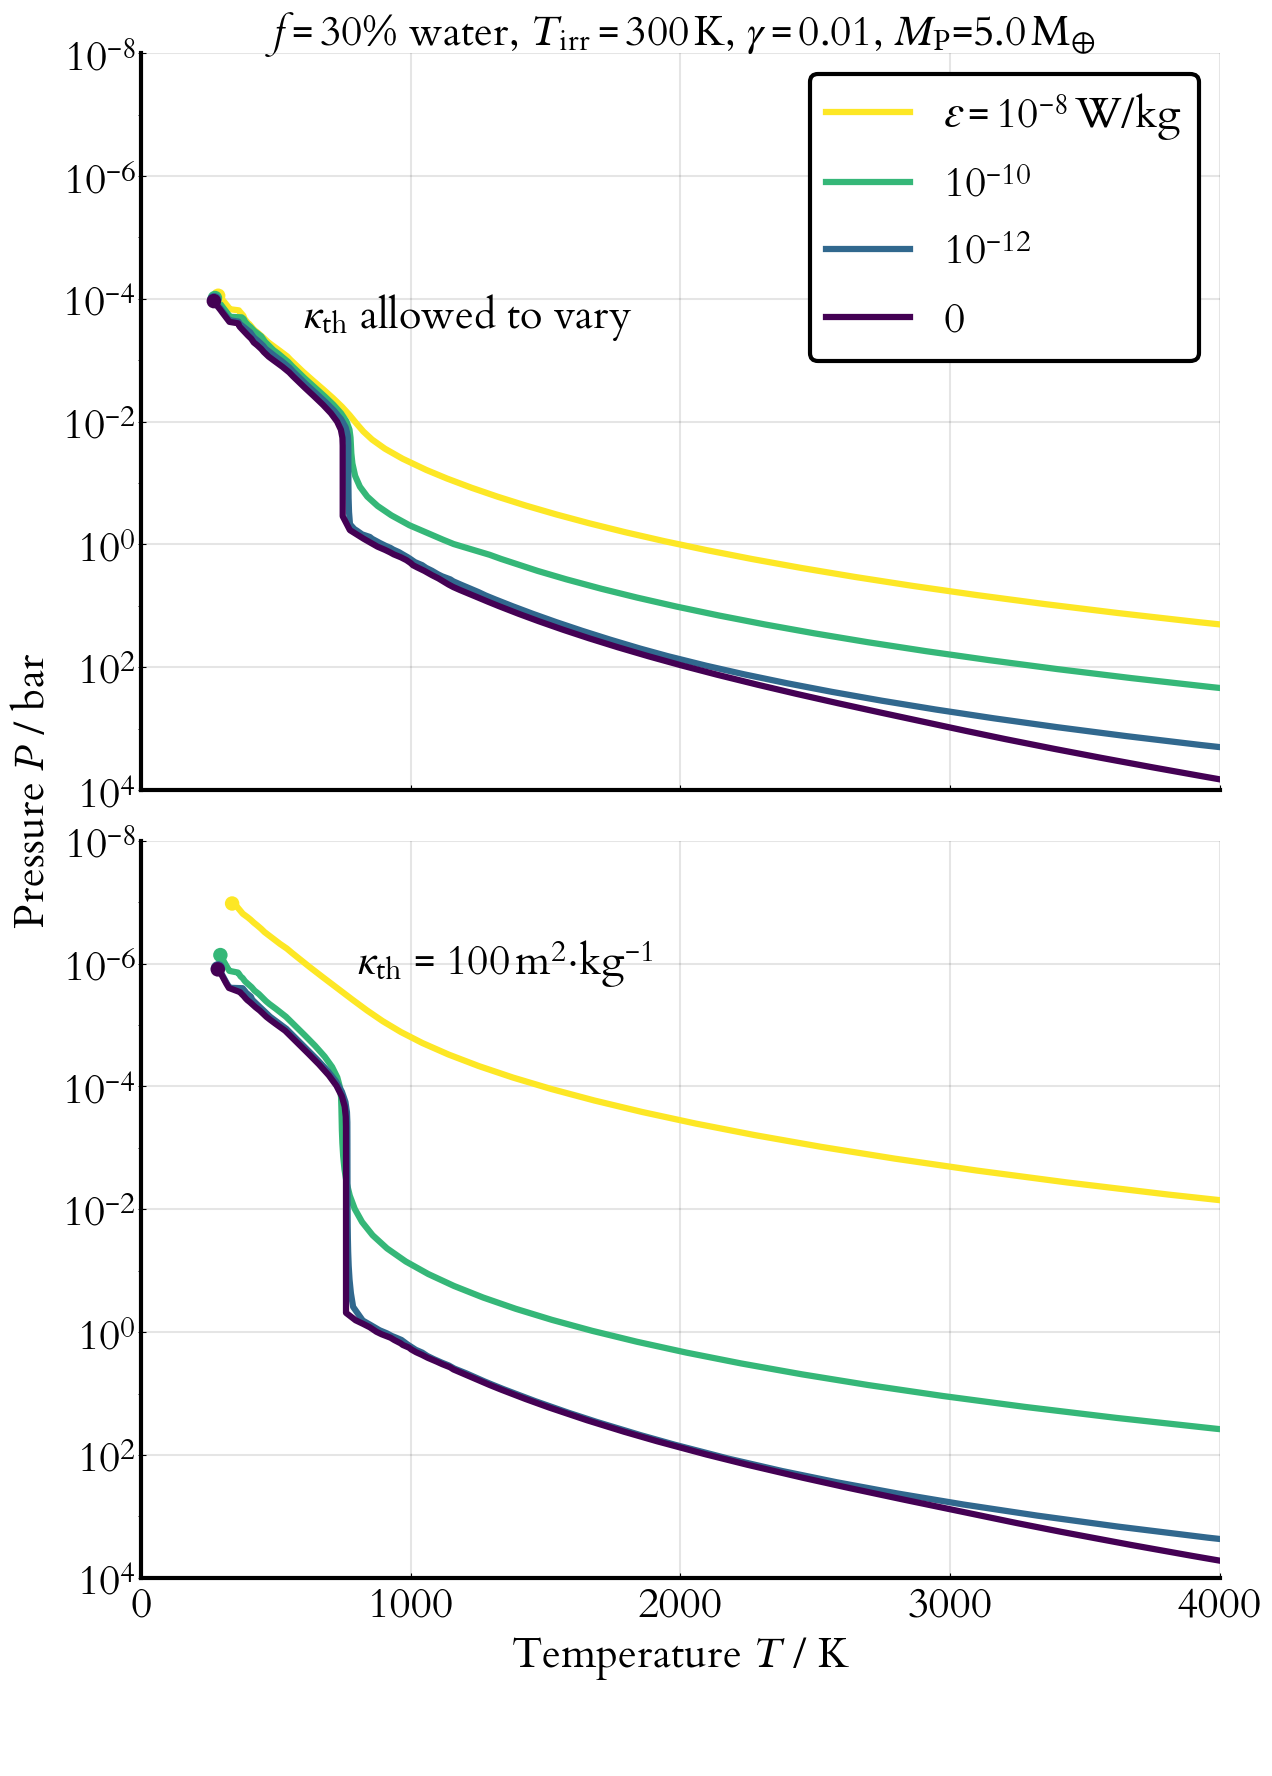

In [5]:
autofig("internal-heat-profiles", Normal, vscale=2) do
    d_all = loadfigdata("onion", "internal-heat-profiles")
    dn = d_all[string(Onion.water_opacity)]
    d0 = d_all[string(Onion.ConstantOpacity(0))]
    d100 = d_all[string(Onion.ConstantOpacity(100))]
    
    blankfmt = x -> ""
    xlims = (0, 4000)
    ylabel = L"Pressure $P$ / bar"
    ylabel_spaced = repeat(" ", 75) * ylabel
    
    colors = seqcolors(:viridis, length(dn["ɛs"])) |> reverse
    
    top = plot()
    bottom = plot()
    
    let ɛs = dn["ɛs"], Ps = dn["Ps"], Ts = dn["Ts"]
        labels = latex_power.(ɛs) |>
            x -> reshape(x, (1, :))
        addunit!(labels, "W/kg")
        addsym!(labels, "ɛ")
        title = parvalues(L"$f=$f0, $T_\mathrm{irr}=$Tirr0, $γ=$γ0, $M_\mathrm{P}$=M0", dn)
        
        plot!(top, Ts/K, Ps/bar,
            title=title, labels=labels, palette=colors,
            xaxis=(xlims, blankfmt), 
            yaxis=(:log10, :flip, (1e-8, 1e4)))
        Tphots = [T[1] for T in Ts]
        Pphots = [P[1] for P in Ps]
        scatter!(top, Tphots/K, Pphots/bar, label="", c=colors, markerstrokewidth=0, markersize=6)
        
        annotate_color!(600, 2e-4, L"$κ_\mathrm{th}$ allowed to vary", :black)
    end
    
#     let Ps = d0["Ps"], Ts = d0["Ts"]
#         plot!(bottom, Ts/K, Ps/bar, s=:dash, label="", c=:dimgrey, lw=1,
#             xaxis=(xlims, L"Temperature $T$ / K"),
#             yaxis=(:log10, :flip, (1e-8, 1e4)))
#         annotate_color!(80, 1e-1, L"$κ_\mathrm{th}$ = 0$\,$m$^2⋅$kg$^{-1}$", :dimgrey, rotation=90)
#     end 
    
    let Ps = d100["Ps"], Ts=d100["Ts"]
        plot!(bottom, Ts/K, Ps/bar, label="", palette=colors,
              xaxis=(xlims, L"Temperature $T$ / K"),
              yaxis=(:log10, :flip, (1e-8, 1e4)))
        annotate_color!(800, 1e-6, L"$κ_\mathrm{th}$ = 100$\,$m$^2⋅$kg$^{-1}$", :black)
        ylabel!(bottom, ylabel_spaced)
        Tphots = [T[1] for T in Ts]
        Pphots = [P[1] for P in Ps]
        scatter!(bottom, Tphots/K, Pphots/bar, label="", c=colors, markerstrokewidth=0, markersize=6)
    end
    
    plot(top, bottom, layout=grid(2,1))
end;

#### Irradiation

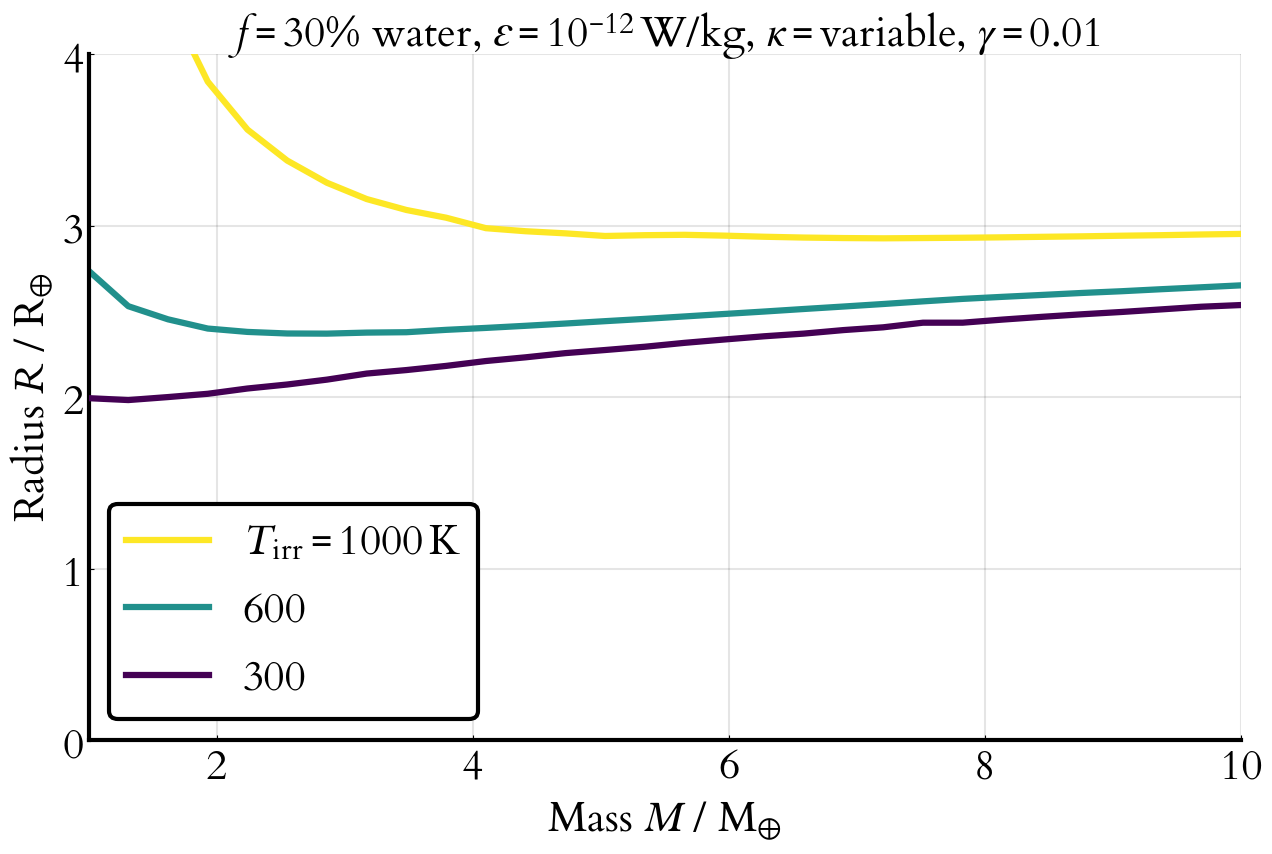

In [6]:
autofig("irradiation", Normal) do
    d = loadfigdata("onion", "irradiation")
    colors = seqcolors(:viridis, length(d["Tirrs"])) |> reverse
    
    let Tirrs = d["Tirrs"], Ms = d["Ms"], Rs = d["Rs"]
        labels = string.(Tirrs) |>
            x -> reshape(x, (1, :))
        addunit!(labels, "K")
        addsym!(labels, "T_\\mathrm{irr}")
        title = parvalues(L"$f=$f0, $ɛ=$ɛ0, $κ=$κ0, $γ=$γ0", d)
        plot(Ms/M_earth, Rs/R_earth, label=labels, xaxis=xaxis, yaxis=yaxis, title=title, palette=colors)
    end
end;

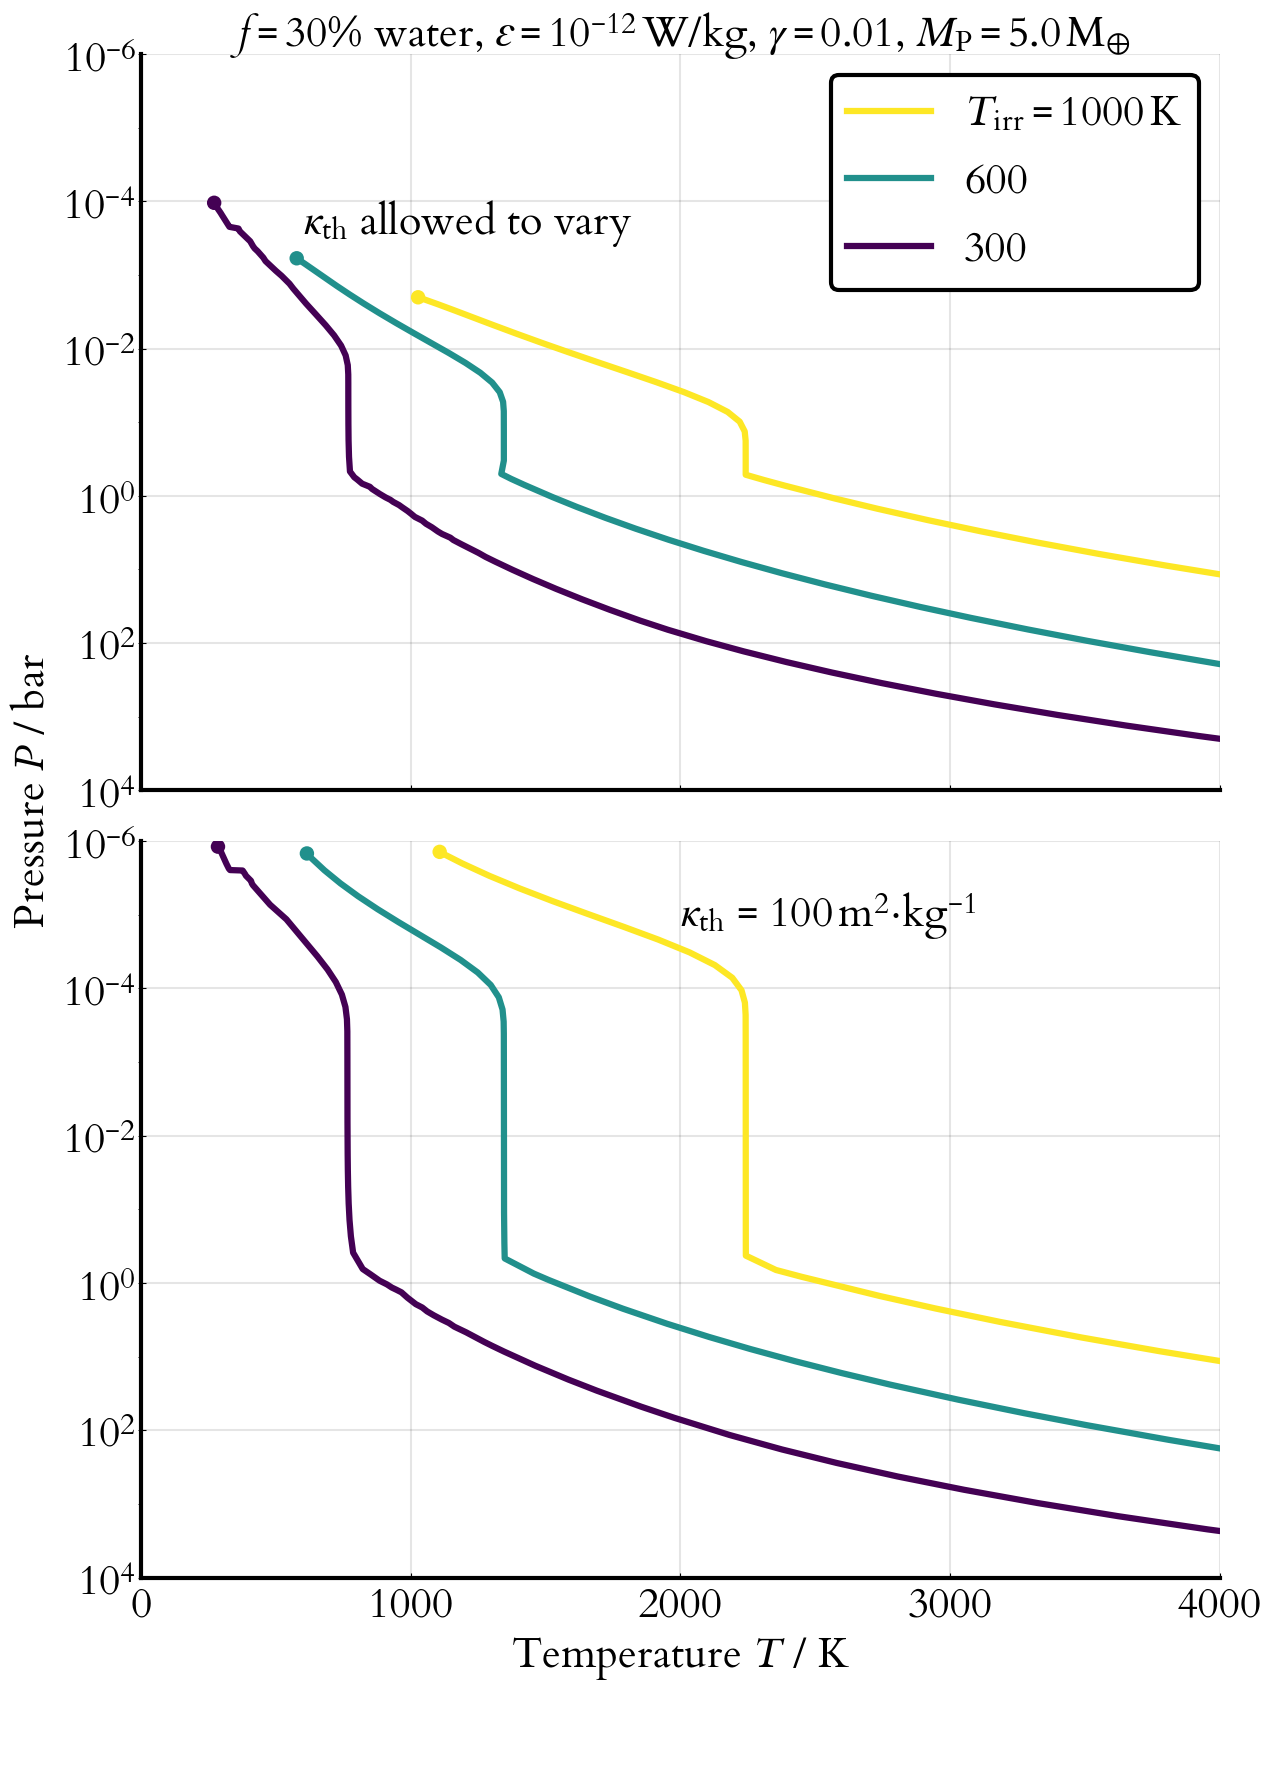

In [7]:
autofig("irradiation-profiles", Normal, vscale=2) do
    d_all = loadfigdata("onion", "irradiation-profiles")
    dn = d_all[string(Onion.water_opacity)]
    d0 = d_all[string(Onion.ConstantOpacity(0))]
    d100 = d_all[string(Onion.ConstantOpacity(100))]
    
    blankfmt = x -> ""
    xlims = (0, 4000)
    ylabel = L"Pressure $P$ / bar"
    ylabel_spaced = repeat(" ", 75) * ylabel
    
    colors = seqcolors(:viridis, length(dn["Tirrs"])) |> reverse
    
    top = plot()
    bottom = plot()
    
    let Tirrs = dn["Tirrs"], Ps = dn["Ps"], Ts = dn["Ts"]
        labels = string.(Tirrs) |>
            x -> reshape(x, (1, :))
        addunit!(labels, "K")
        addsym!(labels, "T_\\mathrm{irr}")
        title = parvalues(L"$f=$f0, $ɛ=$ɛ0, $γ=$γ0, $M_\mathrm{P}=$M0", dn)

        plot!(top, Ts/K, Ps/bar,
            title=title, labels=labels, palette=colors,
            xaxis=(xlims, blankfmt), 
            yaxis=(:log10, :flip, (1e-6, 1e4)))
        Tphots = [T[1] for T in Ts]
        Pphots = [P[1] for P in Ps]
        scatter!(top, Tphots/K, Pphots/bar, label="", c=colors, markerstrokewidth=0, markersize=6)
        
        annotate_color!(600, 2e-4, L"$κ_\mathrm{th}$ allowed to vary", :black)
    end
    
#     let Ps = d0["Ps"], Ts = d0["Ts"]
#         plot!(bottom, Ts/K, Ps/bar, s=:dash, label="", c=:dimgrey, lw=1,
#             xaxis=(xlims, L"Temperature $T$ / K"),
#             yaxis=(:log10, :flip, (1e-6, 1e4)))
#         annotate_color!(40, 1e-1, L"$κ_\mathrm{th}$ = 0$\,$m$^2⋅$kg$^{-1}$", :dimgrey, rotation=90)
#     end 
    
    let Ps = d100["Ps"], Ts=d100["Ts"]
        plot!(bottom, Ts/K, Ps/bar, label="", palette=colors,
              xaxis=(xlims, L"Temperature $T$ / K"),
              yaxis=(:log10, :flip, (1e-6, 1e4)))
        ylabel!(bottom, ylabel_spaced)
        annotate_color!(2000, 1e-5, L"$κ_\mathrm{th}$ = 100$\,$m$^2⋅$kg$^{-1}$", :black)
        Tphots = [T[1] for T in Ts]
        Pphots = [P[1] for P in Ps]
        scatter!(bottom, Tphots/K, Pphots/bar, label="", c=colors, markerstrokewidth=0, markersize=6)
    end
    
    plot(top, bottom, layout=grid(2,1))
end;

### Core fraction

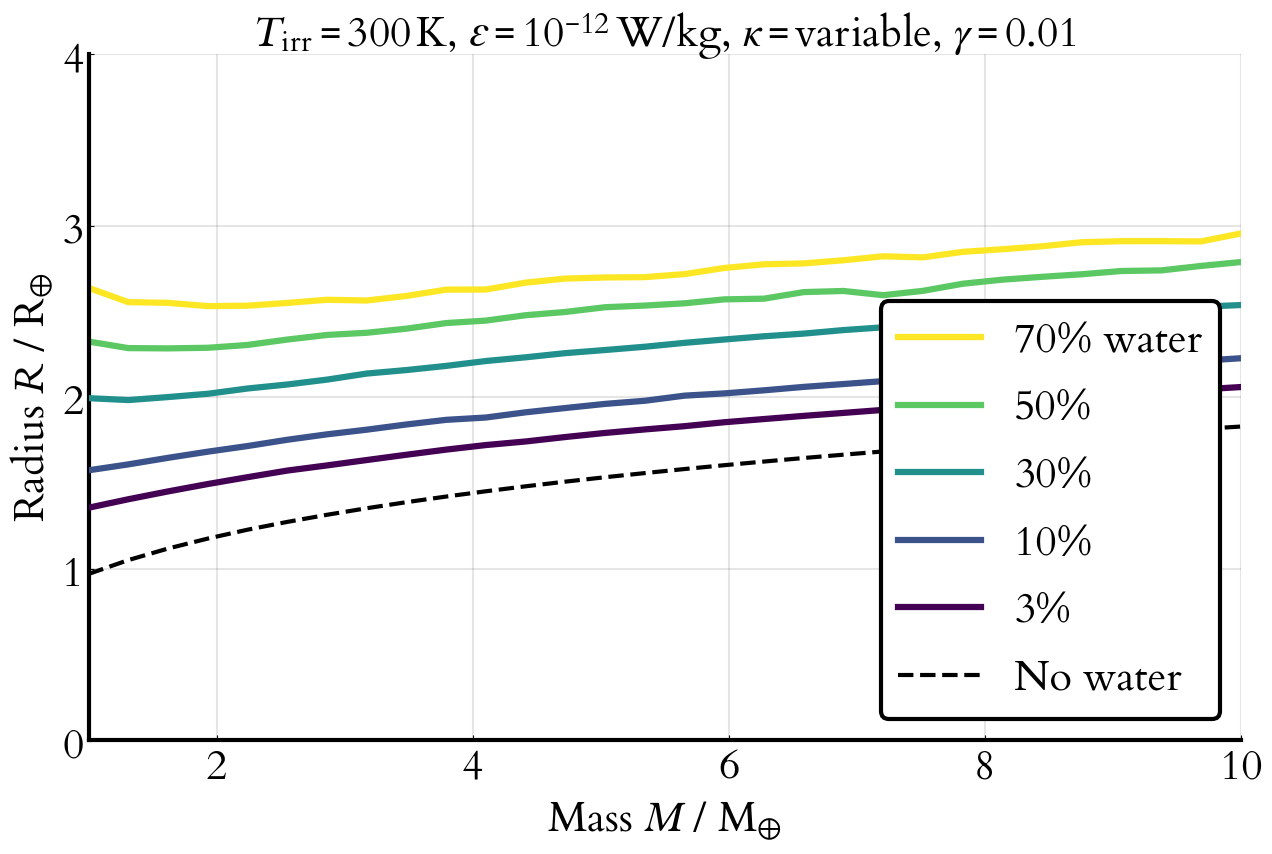

In [8]:
autofig("core-fraction", Normal) do
    d = loadfigdata("onion", "core-fraction")
    colors = seqcolors(:viridis, length(d["fs"])) |> reverse
    
    let fs = d["fs"], Ms = d["Ms"], Rs = d["Rs"], Rs_rock = d["Rs_rock"]
        wfrac_percent = map(f -> 100 - trunc(Int, 100f), fs)
        labels = map(wf -> "$wf%", wfrac_percent) |>
            x -> reshape(x, (1, :))
        labels[1] *= " water"
        title = parvalues(L"$T_\mathrm{irr}=$Tirr0, $ɛ=$ɛ0, $κ=$κ0, $γ=$γ0", d)
        plot(Ms/M_earth, Rs/R_earth, label=labels, xaxis=xaxis, yaxis=yaxis, title=title, palette=colors)
        plot!(Ms/M_earth, Rs_rock/R_earth, linewidth=1, linestyle=:dash, color=:black, label="No water")
    end
end;

### Atmospheric treatments

#### Opacity

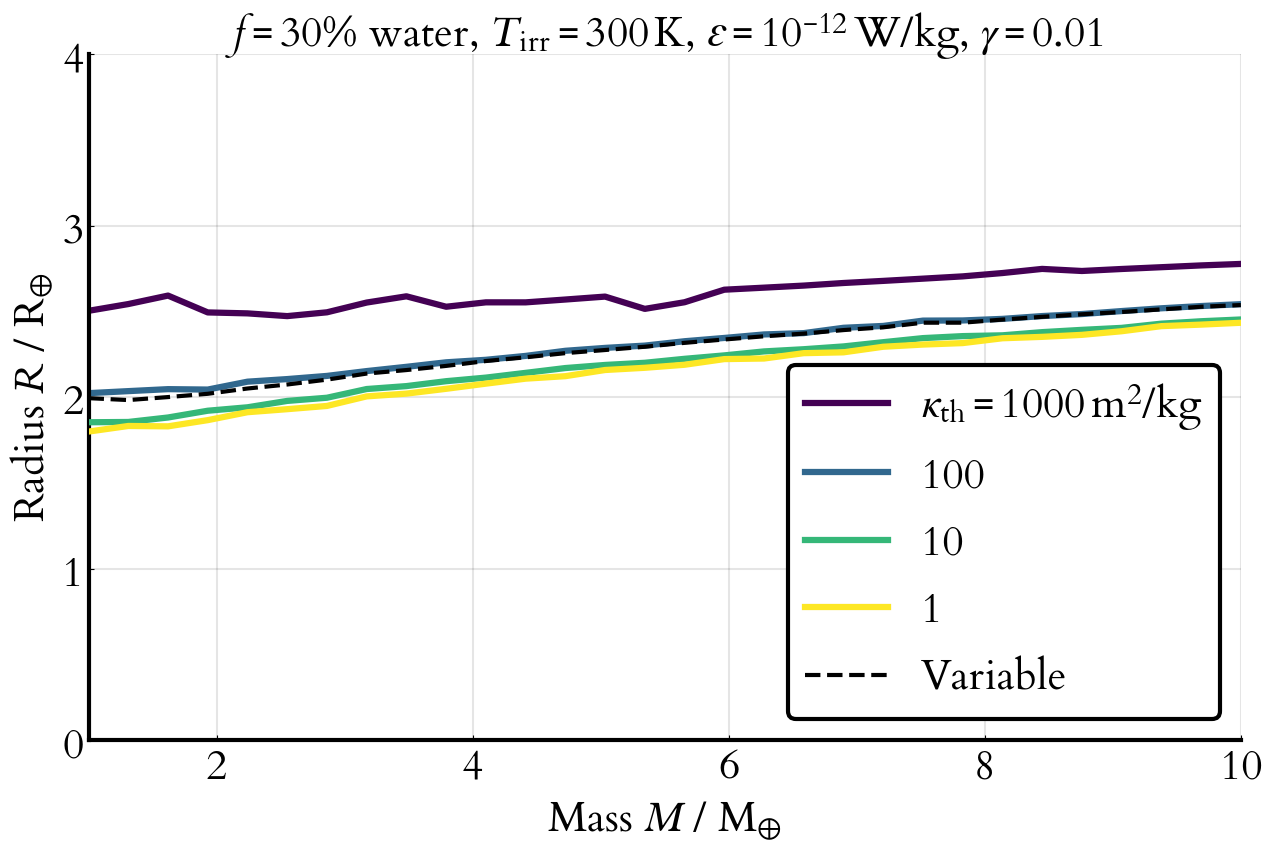

In [9]:
Base.repr(op::Onion.Opacity) = string(trunc(Int, op.C))

autofig("opacities", Normal) do
    d = loadfigdata("onion", "opacities")
    colors = seqcolors(:viridis, 4)
     
    let κs = d["κs"], Ms = d["Ms"], Rs = d["Rs"], Rs_freeκ = d["Rs_freeκ"]
        labels = map(κ -> repr(κ), κs) |>
            x -> reshape(x, (1, :))
        addunit!(labels, "m\$^2\$/kg")
        addsym!(labels, "κ_\\mathrm{th}")
        title = parvalues(L"$f=$f0, $T_\mathrm{irr}=$Tirr0, $ɛ=$ɛ0, $γ=$γ0", d)
        plot(Ms/M_earth, Rs/R_earth, label=labels, xaxis=xaxis, yaxis=yaxis, title=title, palette=colors)
        plot!(Ms/M_earth, Rs_freeκ/R_earth, linestyle=:dash, 
             color=:black, label="Variable", linewidth=1)
    end
end;

#### Opacity ratio

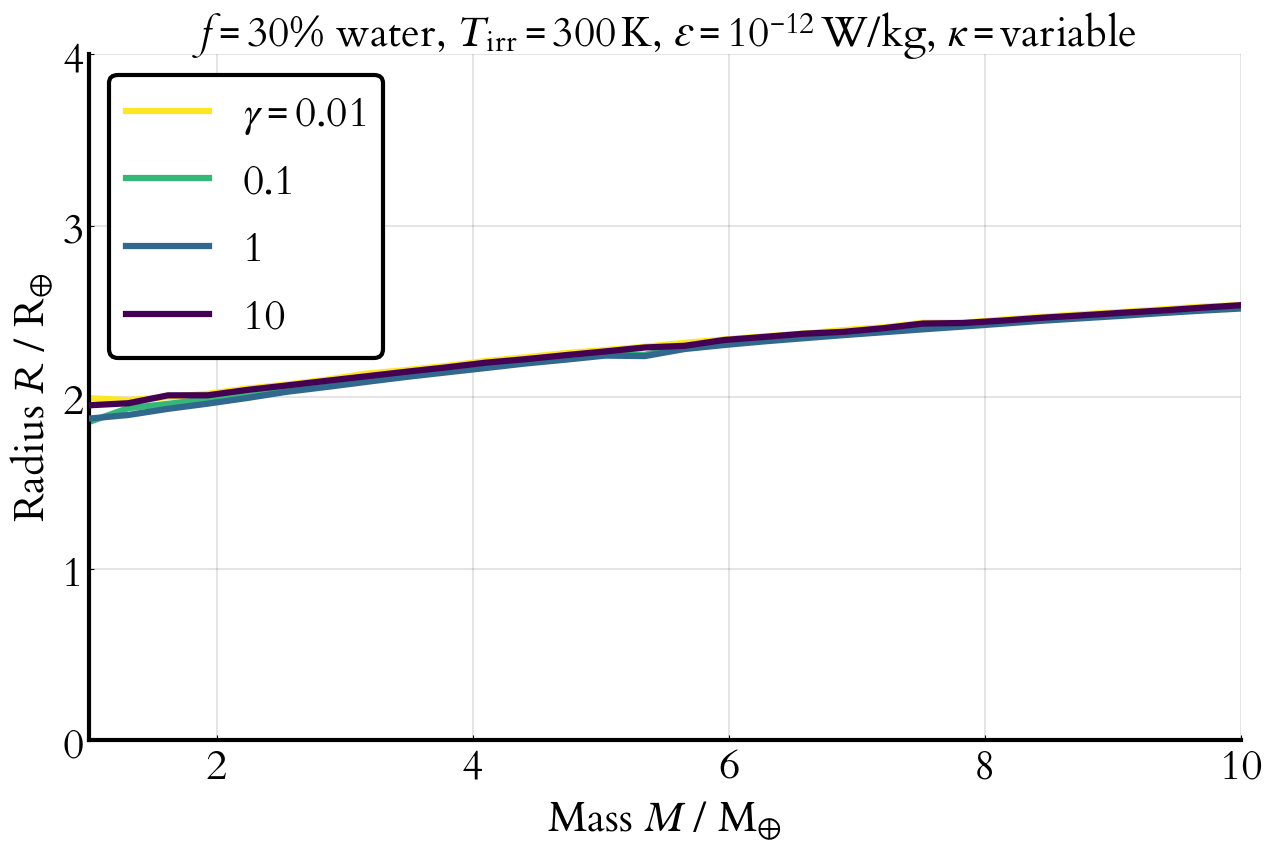

In [10]:
autofig("opacity-ratio", Normal) do
    d = loadfigdata("onion", "opacity-ratios")
    colors = seqcolors(:viridis, 4) |> reverse
    
    let γs = d["γs"], Ms = d["Ms"], Rs = d["Rs"]
        labels = map(γ -> "$γ", γs) |>
            x -> reshape(x, (1, :))
        addsym!(labels, "γ")
        title = parvalues(L"$f=$f0, $T_\mathrm{irr}=$Tirr0, $ɛ=$ɛ0, $κ=$κ0", d)
        plot(Ms/M_earth, Rs/R_earth, label=labels, xaxis=xaxis, yaxis=yaxis, title=title, palette=colors)
    end
end;

### Atmospheric thickness comparisons

#### Externally heated & scale height

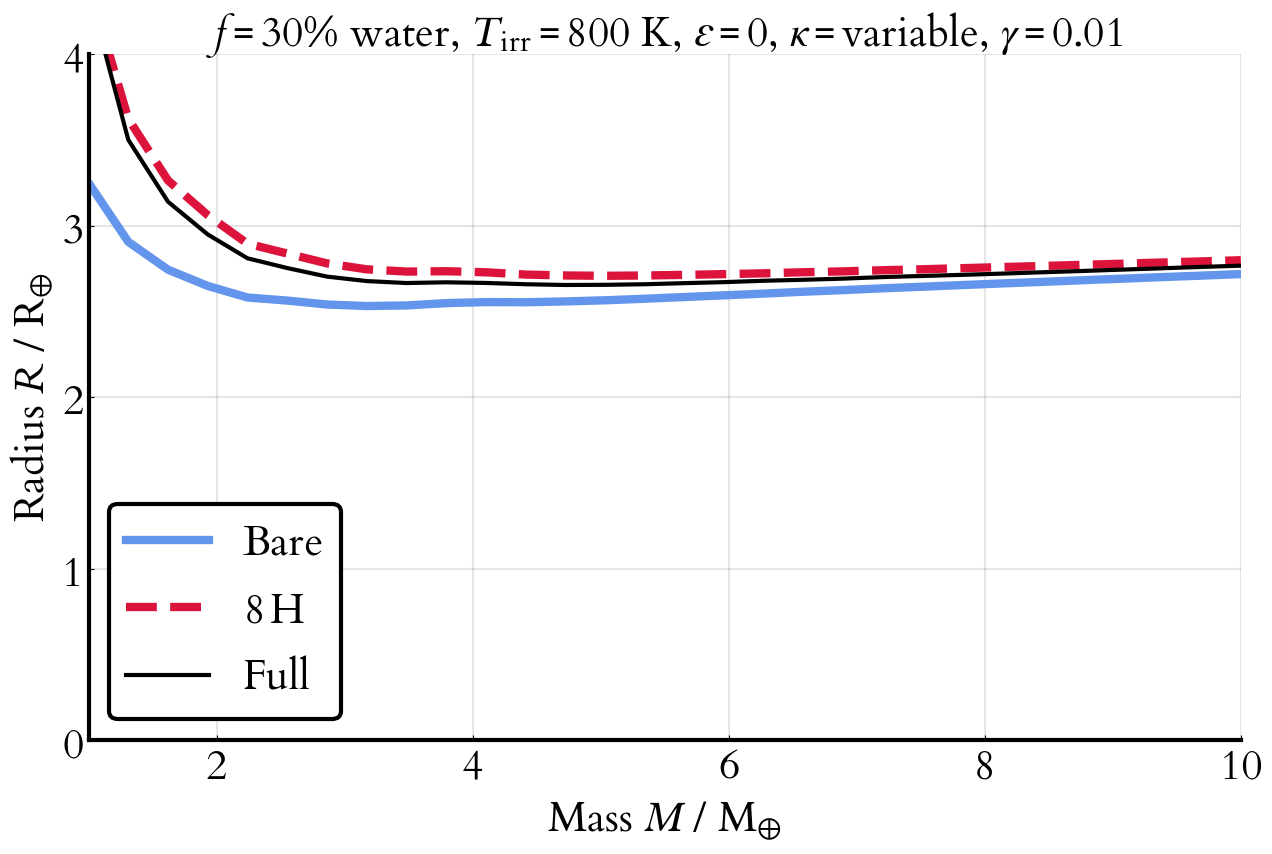

In [11]:
autofig("atmospheric-thickness", Normal) do
    d = loadfigdata("onion", "atmospheric-thickness")
    Tirrs = d["Tirrs"]
    Nscale = d["Nscale"]
    
    Tirr = 800
    let Ms = d["Ms"], Rs_bare = d["Rs_bare"][Tirr], Rs_full = d["Rs_full"][Tirr],
        Hs = d["Hs"][Tirr]

        title = parvalues(L"$f=$f0, $T_\mathrm{irr}=$Tirr, $ɛ=$0, $κ=$κ0, $γ=$γ0", d)
        title = replace(title, "Tirr", string(Tirr) * " K")

        labels = ["Bare" (string(Nscale)*L"$\,$H") "Full"]
        linewidths = [2 2 1]
        linestyles = [:solid :dash :solid]
        linecolors = [:cornflowerblue :crimson :black]
        Rs_combined = hcat(Rs_bare, Rs_bare + Nscale*Hs, Rs_full)
        p = plot(Ms/M_earth, Rs_combined/R_earth, xaxis=xaxis, yaxis=yaxis, 
        label=labels, linewidth=linewidths, linestyle=linestyles, title=title,
        color=linecolors)
    end
end;

#### Internal-external comparison

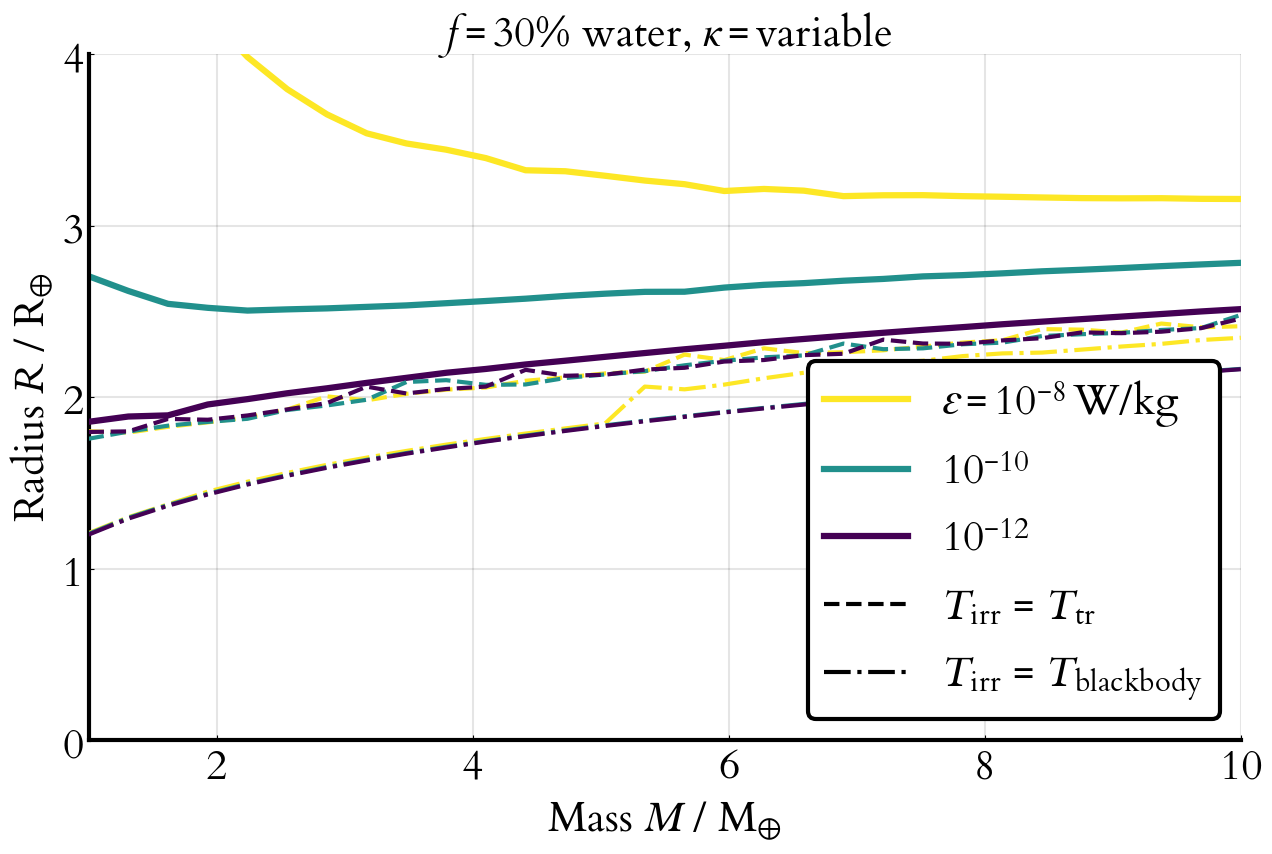

In [12]:
autofig("internal-vs-external", Normal) do
    d = loadfigdata("onion", "internal-vs-external")
    
    let Ms = d["Ms"], Rs_i = d["Rs_internal"], ɛs = d["ɛs"],
        Rs_e1 = d["Rs_external_transition"], Rs_e2 = d["Rs_external_blackbody"]
        
        title = parvalues(L"$f=$f0, $κ=$κ0", d)
        labels = latex_power.(ɛs) |>
            x -> reshape(x, (1, :))
        addunit!(labels, "W/kg")
        addsym!(labels, "ɛ")
        colors = [:cornflowerblue :coral :limegreen :darkviolet]
        colors = seqcolors(:viridis, 3) |> reverse
        colors = reshape(colors, (1, 3))
        
        p = plot(Ms/M_earth, Rs_i/R_earth, label=labels, xaxis=xaxis, yaxis=yaxis, 
        title=title, color=colors)
        plot!(Ms/M_earth, Rs_e1/R_earth, linestyle=:dash, linewidth=1, label="",
        linecolor=colors)
        plot!(Ms/M_earth, Rs_e2/R_earth, linestyle=:dashdot, linewidth=1, label="",
        linecolor=colors)
        plot!([-99, -99], linestyle=:dash, label=L"$T_\mathrm{irr}$ = $T_\mathrm{tr}$", color=:black, linewidth=1)
        plot!([-99, -99], linestyle=:dashdot, label=L"$T_\mathrm{irr}$ = $T_\mathrm{blackbody}$", color=:black, linewidth=1)
        ylims!(0, 4)
    end
end;